In [1]:
import sys
print(sys.executable)


/opt/campux/virtualenv/deeplearning-u24/bin/python3


In [2]:
import torch
torch.__version__


'2.4.1+cu121'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



device(type='cuda')

In [4]:
transform = transforms.ToTensor() # convert data to torch.FloatTensor

train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform)

num_train, num_test = len(train_data), len(test_data)
print('number of training data:', num_train, '\n'+'number of test data:', num_test)


Files already downloaded and verified
Files already downloaded and verified
number of training data: 50000 
number of test data: 10000


In [5]:

pretrained_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
# Set random seed for reproducibility


Using cache found in /homes/n24lachg/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [20]:
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
)

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)


# Load pretrained ResNet-20
model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models",
    "cifar10_resnet20",
    pretrained=True
).to(device)

model.eval()


Files already downloaded and verified


Using cache found in /homes/n24lachg/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [7]:
def deepfool(model, image, num_classes=10, overshoot=0.02, max_iter=50):
    """
    image: [1, 1, 28, 28]
    return: x_adv, perturbation (tensor)
    """

    model.eval()
    x = image.clone().detach().to(device)
    x.requires_grad_(True)

    # Initial prediction
    with torch.no_grad():
        logits = model(x)
    label = logits.argmax().item()

    pert_total = torch.zeros_like(x).to(device)

    for _ in range(max_iter):

        # Forward
        logits = model(x)
        preds = logits.argmax().item()
        
        # Stop if model is fooled
        if preds != label:
            break

        # Compute gradient of true class
        logits[0, label].backward(retain_graph=True)
        grad_orig = x.grad.data.clone()

        # Compute perturbations for all other classes
        min_pert = float("inf")
        w_best = None

        for k in range(num_classes):
            if k == label:
                continue

            x.grad.zero_()
            logits[0, k].backward(retain_graph=True)
            grad_k = x.grad.data.clone()

            w_k = grad_k - grad_orig
            f_k = (logits[0, k] - logits[0, label]).item()

            pert_k = abs(f_k) / (w_k.flatten().norm() + 1e-8)

            if pert_k < min_pert:
                min_pert = pert_k
                w_best = w_k

        # Compute minimal perturbation
        r_i = (min_pert + 1e-4) * w_best / (w_best.flatten().norm() + 1e-8)
        pert_total += r_i

        # Update image
        x = (image + (1 + overshoot) * pert_total).detach()
        x.requires_grad_(True)

    x_adv = torch.clamp(x, 0, 1)
    return x_adv.detach(), pert_total.detach()


In [9]:
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

x_adv, r = deepfool(model, x)

print("Original label:", y.item())
print("Adversarial label:", model(x_adv).argmax().item())
print("L2 norm of perturbation:", torch.norm(r).item())


Original label: 6
Adversarial label: 3
L2 norm of perturbation: 0.474595308303833


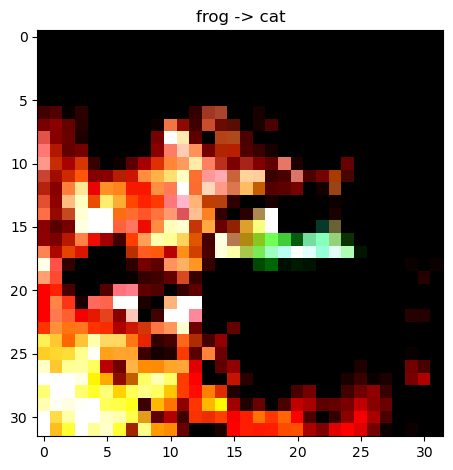

In [17]:
# Plot several examples of adversarial samples at each epsilon
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']
y_pred= model(x_adv).argmax().item()
orig,adv=x,x_adv
plt.title(f"{cifar_classes[y.item()]} -> {cifar_classes[y_pred]}")
plt.imshow(adv.detach().cpu().squeeze().permute(1, 2, 0).numpy())
plt.tight_layout()
plt.show()


In [25]:
from torch.utils.data import Subset, DataLoader
subset200 = Subset(test_data, list(range(5000)))
test_loader200 = DataLoader(subset200, batch_size=1, shuffle=False)

correct = 0
total = 0

for i, (x, y) in enumerate(test_loader200):
    x = x.to(device)
    y = y.to(device)

    # génération de l'adversarial
    x_adv, _ = deepfool(model, x)

    # prédiction du modèle sur l'exemple adversarial
    pred = model(x_adv).argmax()

    correct += (pred == y).item()
    total += 1

print("DeepFool Adversarial Accuracy (subset) :", correct / total)





DeepFool Adversarial Accuracy (subset) : 0.4578


In [27]:
L2_list = []

for i, (x, _) in enumerate(test_loader):
    if i >= 200:
        break

    x = x.to(device)
    _, r = deepfool(model, x)
    L2_list.append(torch.norm(r).item())

print("Mean L2:", np.mean(L2_list))
print("Std L2:", np.std(L2_list))


KeyboardInterrupt: 

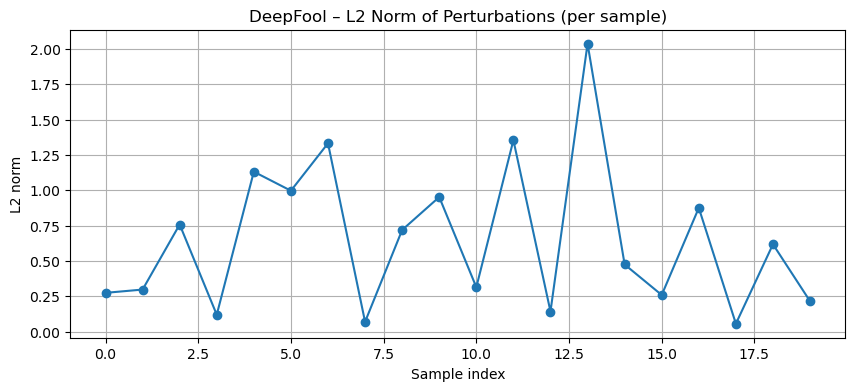

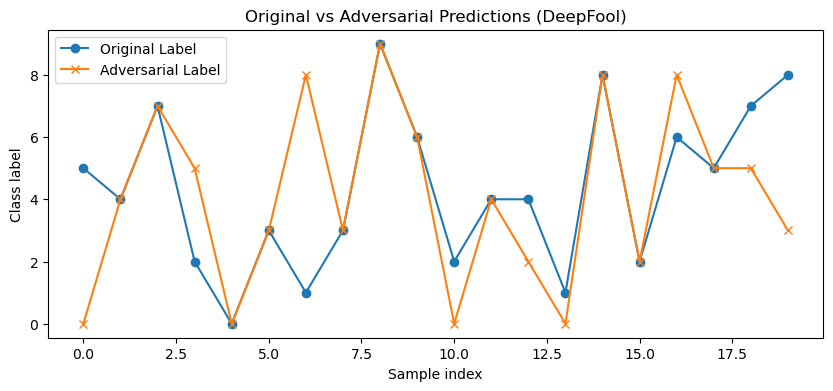

In [28]:
import matplotlib.pyplot as plt


N = 20  

images_orig = []
images_adv = []
perturbs = []
labels_orig = []
labels_adv = []
norms_l2 = []

data_iter = iter(test_loader)

for i in range(N):
    x, y = next(data_iter)
    x = x.to(device)
    y = y.to(device)

    x_adv, r = deepfool(model, x)
    
    images_orig.append(x.cpu())
    images_adv.append(x_adv.cpu())
    perturbs.append((x_adv - x).cpu())
    
    labels_orig.append(y.item())
    labels_adv.append(model(x_adv).argmax().item())
    norms_l2.append(torch.norm(r).item())



plt.figure(figsize=(10,4))
plt.plot(norms_l2, marker='o')
plt.title("DeepFool – L2 Norm of Perturbations (per sample)")
plt.xlabel("Sample index")
plt.ylabel("L2 norm")
plt.grid(True)
plt.show()



plt.figure(figsize=(10,4))
plt.plot(labels_orig, label="Original Label", marker='o')
plt.plot(labels_adv, label="Adversarial Label", marker='x')
plt.title("Original vs Adversarial Predictions (DeepFool)")
plt.xlabel("Sample index")
plt.ylabel("Class label")
plt.legend()
plt.show()




In [26]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output